In [ ]:
#!pip install spacy-langdetect
#!pip install langid
!pip install mtcnn

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
import cv2
import json
import re
from ast import literal_eval
import nltk
import spacy
#from spacy_langdetect import LanguageDetector
import string
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
#import langid

#from ethnicolr import census_ln, pred_census_ln, pred_fl_reg_name

link to original colab: https://colab.research.google.com/drive/1bp_C0E29O_F4KX8qCGw5aWfLL97-6JPh?usp=sharing

# Age Classification with tweets

### Data Load

In [ ]:
df_users = pd.read_csv("/content/drive/MyDrive/demographicPredictionData/race_data/labeled_users.csv", lineterminator='\n')
print(df_users.shape)
print(df_users.columns)
print(df_users.head())

(1145, 26)
Index(['Unnamed: 0', 'Unnamed: 0.1', 'screen_name', 'user_id', 'lang', 'name',
       'location', 'description', 'protected', 'followers_count',
       'friends_count', 'statuses_count', 'favourites_count',
       'account_created_at', 'verified', 'profile_banner_url',
       'profile_background_url', 'profile_image_url', 'user.name',
       'num.tweets.used.Lexicon.prediction', 'Lexicon.age.prediction',
       'Lexicon.gender.prediction..index.', 'lexicon.gender.prediction',
       'human.labeled.gender', 'human.labeled.age', 'age'],
      dtype='object')
   Unnamed: 0  Unnamed: 0.1  ... human.labeled.age  age
0           0             1  ...              23.0  1.0
1           1             2  ...              19.0  0.0
2           3             4  ...              22.0  0.0
3           8             9  ...              26.0  1.0
4           9            10  ...              20.0  0.0

[5 rows x 26 columns]


In [ ]:
def get_name(name):
  return name[1:]

df_users['user.name'] = df_users['user.name'].apply(get_name)
print(df_users.shape)
print(df_users.head())

(1145, 26)
   Unnamed: 0  Unnamed: 0.1  ... human.labeled.age  age
0           0             1  ...              23.0  1.0
1           1             2  ...              19.0  0.0
2           3             4  ...              22.0  0.0
3           8             9  ...              26.0  1.0
4           9            10  ...              20.0  0.0

[5 rows x 26 columns]


In [ ]:
df_users['user.name']

0         _____zac_____
1              ___aleia
2       ___schaeffer___
3               __drewc
4         __EmilyRice__
             ...       
1140        zmeadows_18
1141         ZoeBerrier
1142        ZoeCalamaco
1143           ZoPeachy
1144          zzzakari4
Name: user.name, Length: 1145, dtype: object

In [ ]:
with open('/content/drive/MyDrive/demographicPredictionData/race_data/tweets.json') as json_data:
  data = json.load(json_data)
df_twitter = pd.DataFrame(list(data.items()),columns = ['user.name','tweets'])
print(df_twitter.shape)
print(df_twitter.head())

(2678, 2)
         user.name                                             tweets
0    _____zac_____  [@AdvoBarryRoux @GetVidBot, The owner of drip ...
1         ___aleia  [I haven’t talked to this girl since my sophom...
2          ___Dals  [It come wit it 😭 https://t.co/ENyEtlphtP, @na...
3  ___schaeffer___  [☝🏼👋🏼 https://t.co/xGJLlzLR7g, https://t.co/7N...
4   __andresiscool  [Enough https://t.co/gLarVLIHxW, Some of the w...


In [ ]:
df = pd.merge(df_twitter, df_users, on="user.name")
#df = df.drop(columns=['img_path'], axis=1)
#df['tweets'] = df['user_id'].map(lambda x: data[str(x)] if str(x) in data else np.nan)
print(df.shape)
print(df.head())

(1145, 27)
         user.name  ...  age
0    _____zac_____  ...  1.0
1         ___aleia  ...  0.0
2  ___schaeffer___  ...  0.0
3          __drewc  ...  1.0
4    __EmilyRice__  ...  0.0

[5 rows x 27 columns]


In [ ]:
df.iloc[0]

user.name                                                                 _____zac_____
tweets                                [@AdvoBarryRoux @GetVidBot, The owner of drip ...
Unnamed: 0                                                                            0
Unnamed: 0.1                                                                          1
screen_name                                                               _____zac_____
user_id                                                                     4.61441e+08
lang                                                                                 en
name                                                                            zac ¢
location                                                                  Maryland, USA
description                                                      _____Û___È_Ü´Ù
protected                                                                         False
followers_count                 

In [ ]:
df.to_csv("/content/drive/MyDrive/demographicPredictionData/race_data/age_data.csv", encoding="utf-8")

### merge files, detect language, count marks and pos_tag

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/demographicPredictionData/race_data/age_data.csv", lineterminator='\n')
df['tweets'] = df['tweets'].apply(literal_eval)
df = df.drop(columns=df.columns[0], axis=1)
print(df.shape)
print(df.head())
print(df.columns)

(1145, 27)
         user.name  ...  age
0    _____zac_____  ...  1.0
1         ___aleia  ...  0.0
2  ___schaeffer___  ...  0.0
3          __drewc  ...  1.0
4    __EmilyRice__  ...  0.0

[5 rows x 27 columns]
Index(['user.name', 'tweets', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'screen_name',
       'user_id', 'lang', 'name', 'location', 'description', 'protected',
       'followers_count', 'friends_count', 'statuses_count',
       'favourites_count', 'account_created_at', 'verified',
       'profile_banner_url', 'profile_background_url', 'profile_image_url',
       'num.tweets.used.Lexicon.prediction', 'Lexicon.age.prediction',
       'Lexicon.gender.prediction..index.', 'lexicon.gender.prediction',
       'human.labeled.gender', 'human.labeled.age', 'age'],
      dtype='object')


In [ ]:
# pred_name = pred_fl_reg_ln(df, 'name')
# print(pred_name)
#pred_census_ln(df, 'screen_name')
# print(pred_screen_name)
#df

In [ ]:
def delete_links(tweets):
  res = []
  for tweet in tweets:
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www.\S+", "", tweet)
    tweet = re.sub(r"@\S+", "", tweet)
    res.append(tweet)
  return res

def count_exclamation(tweets):
  cnt = 0
  for tweet in tweets:
    for c in tweet:
      if c == '!':
        cnt += 1
  return cnt

def count_question(tweets):
  cnt = 0
  for tweet in tweets:
    for c in tweet:
      if c == '?':
        cnt += 1
  return cnt

def count_duplicate(tweets):
  cnt = 0
  for tweet in tweets:
    if len(tweet) < 3:
      continue
    for i in range(len(tweet)):
      if tweet[i] == tweet[i-1] and tweet[i-1] == tweet[i-2]:
        cnt += 1
  return cnt

def remove_punct(tweet):
  tweet  = "".join([char for char in tweet if char not in string.punctuation])
  tweet = re.sub('[0-9]+', '', tweet)
  return tweet

def tokenization(tweet):
  tweet = re.split('\W+', tweet)
  return tweet
    
def remove_stopwords(tweet):
  stopword = nltk.corpus.stopwords.words('english')
  tweet = [word for word in tweet if word not in stopword]
  return tweet
    
def stemming(tweet):
  ps = nltk.PorterStemmer()
  tweet = [ps.stem(word) for word in tweet]
  return tweet

def lemmatizer(tweet):
  wn = nltk.WordNetLemmatizer()
  tweet = [wn.lemmatize(word) for word in tweet]
  return tweet
  
def detect_language(tweets):
  return langid.classify(tweets[0])


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df['tweets'] = df['tweets'].map(lambda x: delete_links(x))
df.head()

,user.name,tweets,Unnamed: 0.1,Unnamed: 0.1.1,screen_name,user_id,lang,name,location,description,protected,followers_count,friends_count,statuses_count,favourites_count,account_created_at,verified,profile_banner_url,profile_background_url,profile_image_url,num.tweets.used.Lexicon.prediction,Lexicon.age.prediction,Lexicon.gender.prediction..index.,lexicon.gender.prediction,human.labeled.gender,human.labeled.age,age
0,_____zac_____,"[ , The owner of drip doesn't even have 100 mi...",0,1,_____zac_____,4.614412e+08,en,zac ¢,"Maryland, USA",_____Û___È_Ü´Ù,False,208,178,27912,4179,1/11/12 20:19,False,https://pbs.twimg.com/profile_banners/46144118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1226134911...,100.0,27.652434,-1.457167,M,NaN,23.0,1.0
1,___aleia,[I haven’t talked to this girl since my sophom...,1,2,___aleia,7.650000e+17,en,_æ___ dad ___æ_,"Ohio, USA",BLACK. LIVES. MATTER.,False,466,388,3313,23454,8/14/16 19:45,False,https://pbs.twimg.com/profile_banners/76491083...,NaN,http://pbs.twimg.com/profile_images/1271280679...,100.0,24.111464,0.985713,F,NaN,19.0,0.0
2,___schaeffer___,"[☝🏼👋🏼 , , , 37-14-9, congrats sis keep wor...",3,4,___schaeffer___,1.257110e+09,en,Brenden Schaeffer,The Lou,Culver-Stockton College '20 ¢ Ô_Ô_Ô KM 1548...,False,811,660,26670,72205,3/10/13 14:07,False,https://pbs.twimg.com/profile_banners/12571104...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1268044218...,59.0,35.518352,-3.591586,M,NaN,22.0,0.0
3,__drewc,[Yo rly Try Cash App using my code and we’ll e...,8,9,__drewc,1.050000e+18,en,drew,"New York, USA",_öÂ_öé _öÂ_ö_ _ç´Ù È \r\r26 #NewYork,False,27,128,181,113,10/17/18 4:12,False,https://pbs.twimg.com/profile_banners/10524118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1090809548...,134.0,24.910635,1.969121,F,NaN,26.0,1.0
4,__EmilyRice__,[ yes but come to san marcos and live with me ...,9,10,__EmilyRice__,3.797155e+09,en,em,"Marble Falls, TX",#TXST22,False,158,190,1219,2596,10/5/15 23:30,False,https://pbs.twimg.com/profile_banners/37971551...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8415201103...,100.0,25.191925,2.382856,F,NaN,20.0,0.0


In [ ]:
df['cnt_q_mark'] = df['tweets'].map(lambda x: count_question(x))
df['cnt_e_mark'] = df['tweets'].map(lambda x: count_exclamation(x))
df['cnt_dup'] = df['tweets'].map(lambda x: count_duplicate(x))
df.head()

,user.name,tweets,Unnamed: 0.1,Unnamed: 0.1.1,screen_name,user_id,lang,name,location,description,protected,followers_count,friends_count,statuses_count,favourites_count,account_created_at,verified,profile_banner_url,profile_background_url,profile_image_url,num.tweets.used.Lexicon.prediction,Lexicon.age.prediction,Lexicon.gender.prediction..index.,lexicon.gender.prediction,human.labeled.gender,human.labeled.age,age,cnt_q_mark,cnt_e_mark,cnt_dup
0,_____zac_____,"[ , The owner of drip doesn't even have 100 mi...",0,1,_____zac_____,4.614412e+08,en,zac ¢,"Maryland, USA",_____Û___È_Ü´Ù,False,208,178,27912,4179,1/11/12 20:19,False,https://pbs.twimg.com/profile_banners/46144118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1226134911...,100.0,27.652434,-1.457167,M,NaN,23.0,1.0,1,2,18
1,___aleia,[I haven’t talked to this girl since my sophom...,1,2,___aleia,7.650000e+17,en,_æ___ dad ___æ_,"Ohio, USA",BLACK. LIVES. MATTER.,False,466,388,3313,23454,8/14/16 19:45,False,https://pbs.twimg.com/profile_banners/76491083...,NaN,http://pbs.twimg.com/profile_images/1271280679...,100.0,24.111464,0.985713,F,NaN,19.0,0.0,23,0,18
2,___schaeffer___,"[☝🏼👋🏼 , , , 37-14-9, congrats sis keep wor...",3,4,___schaeffer___,1.257110e+09,en,Brenden Schaeffer,The Lou,Culver-Stockton College '20 ¢ Ô_Ô_Ô KM 1548...,False,811,660,26670,72205,3/10/13 14:07,False,https://pbs.twimg.com/profile_banners/12571104...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1268044218...,59.0,35.518352,-3.591586,M,NaN,22.0,0.0,4,10,24
3,__drewc,[Yo rly Try Cash App using my code and we’ll e...,8,9,__drewc,1.050000e+18,en,drew,"New York, USA",_öÂ_öé _öÂ_ö_ _ç´Ù È \r\r26 #NewYork,False,27,128,181,113,10/17/18 4:12,False,https://pbs.twimg.com/profile_banners/10524118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1090809548...,134.0,24.910635,1.969121,F,NaN,26.0,1.0,14,8,28
4,__EmilyRice__,[ yes but come to san marcos and live with me ...,9,10,__EmilyRice__,3.797155e+09,en,em,"Marble Falls, TX",#TXST22,False,158,190,1219,2596,10/5/15 23:30,False,https://pbs.twimg.com/profile_banners/37971551...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8415201103...,100.0,25.191925,2.382856,F,NaN,20.0,0.0,11,4,9


In [ ]:
df['tweets_combined'] = df['tweets'].map(lambda x: " ".join(x))
df['tweets_combined'] = df['tweets_combined'].map(lambda x: remove_punct(x))
df['tweets_combined'] = df['tweets_combined'].map(lambda x: tokenization(x))
df['tweets_combined'] = df['tweets_combined'].map(lambda x: remove_stopwords(x))
df['tweets_combined'] = df['tweets_combined'].map(lambda x: lemmatizer(x))
df['pos_tag'] = df['tweets_combined'].map(lambda x: nltk.pos_tag([i for i in x if i]))
df['tweets_combined'] = df['tweets_combined'].map(lambda x: stemming(x))
df['tweets_combined'] = df['tweets_combined'].map(lambda x: " ".join(x))
df.head()

,user.name,tweets,Unnamed: 0.1,Unnamed: 0.1.1,screen_name,user_id,lang,name,location,description,protected,followers_count,friends_count,statuses_count,favourites_count,account_created_at,verified,profile_banner_url,profile_background_url,profile_image_url,num.tweets.used.Lexicon.prediction,Lexicon.age.prediction,Lexicon.gender.prediction..index.,lexicon.gender.prediction,human.labeled.gender,human.labeled.age,age,cnt_q_mark,cnt_e_mark,cnt_dup,tweets_combined,pos_tag
0,_____zac_____,"[ , The owner of drip doesn't even have 100 mi...",0,1,_____zac_____,4.614412e+08,en,zac ¢,"Maryland, USA",_____Û___È_Ü´Ù,False,208,178,27912,4179,1/11/12 20:19,False,https://pbs.twimg.com/profile_banners/46144118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1226134911...,100.0,27.652434,-1.457167,M,NaN,23.0,1.0,1,2,18,the owner drip doesnt even mill drip compani ...,"[(The, DT), (owner, NN), (drip, NN), (doesnt, ..."
1,___aleia,[I haven’t talked to this girl since my sophom...,1,2,___aleia,7.650000e+17,en,_æ___ dad ___æ_,"Ohio, USA",BLACK. LIVES. MATTER.,False,466,388,3313,23454,8/14/16 19:45,False,https://pbs.twimg.com/profile_banners/76491083...,NaN,http://pbs.twimg.com/profile_images/1271280679...,100.0,24.111464,0.985713,F,NaN,19.0,0.0,23,0,18,I talk girl sinc sophomor year I slid stori ma...,"[(I, PRP), (talked, VBD), (girl, NN), (since, ..."
2,___schaeffer___,"[☝🏼👋🏼 , , , 37-14-9, congrats sis keep wor...",3,4,___schaeffer___,1.257110e+09,en,Brenden Schaeffer,The Lou,Culver-Stockton College '20 ¢ Ô_Ô_Ô KM 1548...,False,811,660,26670,72205,3/10/13 14:07,False,https://pbs.twimg.com/profile_banners/12571104...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1268044218...,59.0,35.518352,-3.591586,M,NaN,22.0,0.0,4,10,24,congrat si keep workin f spend memori day wee...,"[(congrats, NNS), (si, VBP), (keep, VB), (work..."
3,__drewc,[Yo rly Try Cash App using my code and we’ll e...,8,9,__drewc,1.050000e+18,en,drew,"New York, USA",_öÂ_öé _öÂ_ö_ _ç´Ù È \r\r26 #NewYork,False,27,128,181,113,10/17/18 4:12,False,https://pbs.twimg.com/profile_banners/10524118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1090809548...,134.0,24.910635,1.969121,F,NaN,26.0,1.0,14,8,28,Yo rli tri cash app use code get dlnxtrw start...,"[(Yo, NNP), (rly, RB), (Try, NNP), (Cash, NNP)..."
4,__EmilyRice__,[ yes but come to san marcos and live with me ...,9,10,__EmilyRice__,3.797155e+09,en,em,"Marble Falls, TX",#TXST22,False,158,190,1219,2596,10/5/15 23:30,False,https://pbs.twimg.com/profile_banners/37971551...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8415201103...,100.0,25.191925,2.382856,F,NaN,20.0,0.0,11,4,9,ye come san marco live see next week squar ha...,"[(yes, RB), (come, VBN), (san, JJ), (marcos, N..."


In [ ]:
print(df.shape)
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['tweets_combined'].fillna(""))
print(tfidf.shape)

(1145, 32)
(1145, 34827)


In [ ]:
svd = TruncatedSVD(n_components=40, random_state=0)
tfidf_pca = svd.fit_transform(tfidf) 
tweet_tfidf = pd.DataFrame(tfidf_pca,)
df_tfidf = pd.concat([df, tweet_tfidf], axis=1)
df_tfidf

,user.name,tweets,Unnamed: 0.1,Unnamed: 0.1.1,screen_name,user_id,lang,name,location,description,protected,followers_count,friends_count,statuses_count,favourites_count,account_created_at,verified,profile_banner_url,profile_background_url,profile_image_url,num.tweets.used.Lexicon.prediction,Lexicon.age.prediction,Lexicon.gender.prediction..index.,lexicon.gender.prediction,human.labeled.gender,human.labeled.age,age,cnt_q_mark,cnt_e_mark,cnt_dup,tweets_combined,pos_tag,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,_____zac_____,"[ , The owner of drip doesn't even have 100 mi...",0,1,_____zac_____,4.614412e+08,en,zac ¢,"Maryland, USA",_____Û___È_Ü´Ù,False,208,178,27912,4179,1/11/12 20:19,False,https://pbs.twimg.com/profile_banners/46144118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1226134911...,100.0,27.652434,-1.457167,M,NaN,23.0,1.0,1,2,18,the owner drip doesnt even mill drip compani ...,"[(The, DT), (owner, NN), (drip, NN), (doesnt, ...",0.182250,0.010311,-0.050827,0.021081,-0.004496,0.133309,0.122411,-0.018540,-0.007837,0.016225,-0.008896,0.023992,-0.015432,-0.026794,-0.055747,-0.014950,-0.023691,-0.004295,0.040216,0.007115,-0.034233,0.061961,-0.033351,0.034419,0.005288,-0.012992,0.038794,-0.039947,-0.012038,0.031020,-0.034647,-0.060290,-0.024418,-0.051185,0.002446,0.008033,0.006136,0.019540,0.005398,-0.014870
1,___aleia,[I haven’t talked to this girl since my sophom...,1,2,___aleia,7.650000e+17,en,_æ___ dad ___æ_,"Ohio, USA",BLACK. LIVES. MATTER.,False,466,388,3313,23454,8/14/16 19:45,False,https://pbs.twimg.com/profile_banners/76491083...,NaN,http://pbs.twimg.com/profile_images/1271280679...,100.0,24.111464,0.985713,F,NaN,19.0,0.0,23,0,18,I talk girl sinc sophomor year I slid stori ma...,"[(I, PRP), (talked, VBD), (girl, NN), (since, ...",0.421480,-0.005196,0.012286,-0.071233,0.008241,-0.016044,-0.064879,0.030147,0.093987,0.003706,0.010887,-0.123765,0.049065,0.001880,-0.082073,-0.072236,0.014217,-0.015302,-0.011231,-0.015166,-0.026028,-0.058842,-0.066511,-0.013608,0.043116,-0.005507,-0.034054,-0.073538,-0.056888,0.012439,-0.068434,0.006496,0.015098,-0.021535,-0.029896,-0.061801,-0.006693,-0.020352,0.106399,-0.048229
2,___schaeffer___,"[☝🏼👋🏼 , , , 37-14-9, congrats sis keep wor...",3,4,___schaeffer___,1.257110e+09,en,Brenden Schaeffer,The Lou,Culver-Stockton College '20 ¢ Ô_Ô_Ô KM 1548...,False,811,660,26670,72205,3/10/13 14:07,False,https://pbs.twimg.com/profile_banners/12571104...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1268044218...,59.0,35.518352,-3.591586,M,NaN,22.0,0.0,4,10,24,congrat si keep workin f spend memori day wee...,"[(congrats, NNS), (si, VBP), (keep, VB), (work...",0.196637,-0.017048,0.017174,0.057946,-0.088193,0.146890,0.211579,0.000535,-0.072917,0.034493,0.008048,-0.045565,-0.037273,-0.019286,0.003544,0.002424,0.040103,-0.035794,0.014275,0.030513,-0.008266,0.026915,0.025963,0.020630,-0.000128,0.022604,0.044920,0.019269,-0.002644,0.004621,-0.004376,-0.016519,0.018394,0.040289,0.008221,-0.005028,-0.060658,-0.025150,-0.008076,0.018778
3,__drewc,[Yo rly Try Cash App using my code and we’ll e...,8,9,__drewc,1.050000e+18,en,drew,"New York, USA",_öÂ_öé _öÂ_ö_ _ç´Ù È \r\r26 #NewYork,False,27,128,181,113,10/17/18 4:12,False,https://pbs.twimg.com/profile_banners/10524118...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1090809548...,134.0,24.910635,1.969121,F,NaN,26.0,1.0,14,8,28,Yo rli tri cash app use code get dlnxtrw start...,"[(Yo, NNP), (rly, RB), (Try, NNP), (Cash, NNP)...",0.292147,0.011468,0.006858,0.021411,0.026597,-0.007389,-0.036262,0.038477,-0.048795,-0.060009,-0.026018,-0.021691,0.009505,-0.046299,0.032095,0.008894,-0.021310,0.019745,0.106966,0.038652,-0.048566,0.021507,-0.008676,-0.011875,-0.059614,0.008834,-0.027677,0.017259,0.055144,-0.027008,-0.024169,-0.017636,-0.103749,0.004435,0

In [ ]:
df_tfidf.to_csv("/content/drive/MyDrive/demographicPredictionData/race_data/age_processed_data.csv")

## Training

In [64]:
df = pd.read_csv("/content/drive/MyDrive/demographicPredictionData/race_data/age_processed_data.csv", lineterminator='\n')
print(df.columns)
print(df.head())

Index(['Unnamed: 0', 'user.name', 'tweets', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'screen_name', 'user_id', 'lang', 'name', 'location', 'description',
       'protected', 'followers_count', 'friends_count', 'statuses_count',
       'favourites_count', 'account_created_at', 'verified',
       'profile_banner_url', 'profile_background_url', 'profile_image_url',
       'num.tweets.used.Lexicon.prediction', 'Lexicon.age.prediction',
       'Lexicon.gender.prediction..index.', 'lexicon.gender.prediction',
       'human.labeled.gender', 'human.labeled.age', 'age', 'cnt_q_mark',
       'cnt_e_mark', 'cnt_dup', 'tweets_combined', 'pos_tag', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39'],
      dtype='object')
   Unnamed: 0        user.name  ...        38        39
0           0    _____zac_

In [65]:
# samples = df[[
#         '0', '1', '2',
#        '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
#        '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
#        '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
#        '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', "human.labeled.age"]]
samples = df.drop(['Unnamed: 0', 'user.name', 'tweets', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'screen_name', 'user_id', 'lang', 'name', 'location', 'description',
       'protected', 'followers_count', 'friends_count', 'statuses_count',
       'favourites_count', 'account_created_at', 'verified',
       'profile_banner_url', 'profile_background_url', 'profile_image_url',
       'num.tweets.used.Lexicon.prediction', 'Lexicon.age.prediction',
       'Lexicon.gender.prediction..index.', 'lexicon.gender.prediction',
       'human.labeled.gender',  'age', 'cnt_q_mark',
       'cnt_e_mark', 'cnt_dup', 'tweets_combined', 'pos_tag', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39'], axis = 1)

def count_age(year):
  if year < 21:
    return 1
  else:
    return 0

le = preprocessing.LabelEncoder()
# le.fit(samples['lang'])
# samples['lang'] = le.transform(samples['lang'])
samples['labels'] = samples['human.labeled.age'].map(lambda x: count_age(x))
#samples = samples[samples["race"]!=4]
print(samples.head())

   human.labeled.age         0         1  ...        28        29  labels
0               23.0  0.182250  0.010311  ... -0.012038  0.031020       0
1               19.0  0.421480 -0.005196  ... -0.056888  0.012439       1
2               22.0  0.196637 -0.017048  ... -0.002644  0.004621       0
3               26.0  0.292147  0.011468  ...  0.055144 -0.027008       0
4               20.0  0.375113 -0.029606  ... -0.021839 -0.000775       1

[5 rows x 32 columns]


In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(
        samples.drop(['labels'], axis=1),
        samples['labels'],
        test_size=1/4.0,
        random_state=0
    )
X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())
print(X_train.head())
print(Y_train.head())
print(X_test.head())

     human.labeled.age         0         1  ...        27        28        29
977           0.473684  0.476513  0.054965  ...  0.421734  0.337938  0.562697
970           0.157895  0.236020  0.056100  ...  0.456401  0.429412  0.272269
629           0.210526  0.657012  0.039274  ...  0.384845  0.323795  0.439738
520           0.175439  0.731103  0.063450  ...  0.368867  0.102092  0.554327
641           0.157895  0.582222  0.072126  ...  0.526517  0.412430  0.498640

[5 rows x 31 columns]
977    0
970    0
629    0
520    0
641    0
Name: labels, dtype: int64
     human.labeled.age         0         1  ...        27        28        29
267           0.115385  0.619198  0.065359  ...  0.596929  0.490039  0.525247
700           0.211538  0.612746  0.080821  ...  0.430506  0.545169  0.413226
622           0.096154  0.720049  0.090785  ...  0.574839  0.411220  0.470128
742           0.076923  0.754040  0.089639  ...  0.690813  0.697880  0.409646
754           0.115385  0.731975  0.026660  ...

[0.77325581 0.77325581 0.77325581 0.69590643 0.76608187]
RMSE on testing set =  0.1951219512195122
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       187
           1       0.71      0.74      0.73       100

    accuracy                           0.80       287
   macro avg       0.78      0.79      0.79       287
weighted avg       0.81      0.80      0.81       287



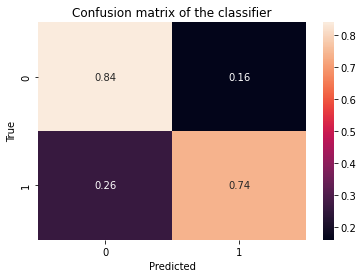

In [67]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=0)
cv_results = cross_validate(lg, X_train, Y_train, scoring=('f1', 'accuracy', 'neg_log_loss'), cv = 5, return_train_score=True)
print(cv_results['test_accuracy'])
lg.fit(X_train, Y_train)
Y_test_predictions_lg = lg.predict(X_test)
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions_lg))
print(sklearn.metrics.classification_report(Y_test, Y_test_predictions_lg))
cm = confusion_matrix(Y_test, Y_test_predictions_lg, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[-2.99740463 -2.69593309 -3.78847273 -3.70469241 -4.28218684]
RMSE on testing set =  0.3867595818815331
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       187
           1       0.44      0.44      0.44       100

    accuracy                           0.61       287
   macro avg       0.57      0.57      0.57       287
weighted avg       0.61      0.61      0.61       287



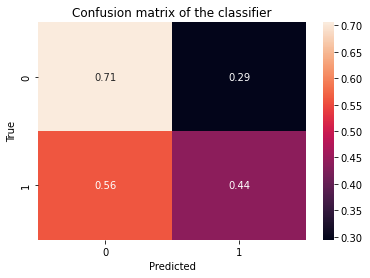

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
cv_results = cross_validate(model, X_train, Y_train, scoring=('f1', 'accuracy', 'neg_log_loss'), cv = 5, return_train_score=True)
print(cv_results['test_neg_log_loss'])
model.fit(X_train, Y_train)
Y_test_predictions_knn = model.predict(X_test)
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions_knn))
print(sklearn.metrics.classification_report(Y_test, Y_test_predictions_knn))
cm = confusion_matrix(Y_test, Y_test_predictions_knn, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# from sklearn.mixture import GaussianMixture

# gm = GaussianMixture(n_components=2, random_state=0)
# cv_results = cross_validate(gm, X_train, Y_train, scoring=('recall', 'precision', 'accuracy', 'neg_log_loss'), cv = 5, return_train_score=True)
# print(cv_results['test_neg_log_loss'])
# gm.fit(X_train, Y_train)
# Y_test_predictions_gm = gm.predict(X_test)
# print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions_gm))
# cm = confusion_matrix(Y_test, Y_test_predictions_gm, normalize='true')
# sns.heatmap(cm, annot=True)
# plt.title('Confusion matrix of the classifier')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

[1.         1.         0.99418605 0.99415205 1.        ]
RMSE on testing set =  0.31010452961672474
              precision    recall  f1-score   support

           0       1.00      0.52      0.69       187
           1       0.53      1.00      0.69       100

    accuracy                           0.69       287
   macro avg       0.76      0.76      0.69       287
weighted avg       0.84      0.69      0.69       287



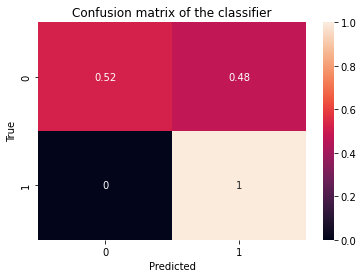

In [69]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0)
cv_results = cross_validate(rf, X_train, Y_train, scoring=('f1', 'accuracy', 'neg_log_loss'), cv = 5, return_train_score=True)
print(cv_results['test_accuracy'])
rf.fit(X_train, Y_train)
Y_test_predictions_rf = rf.predict(X_test)
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions_rf))
print(sklearn.metrics.classification_report(Y_test, Y_test_predictions_rf))
cm = confusion_matrix(Y_test, Y_test_predictions_rf, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/usr/local/lib/python3.7/dist-

[nan nan nan nan nan]
RMSE on testing set =  0.2229965156794425
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       187
           1       0.64      0.83      0.72       100

    accuracy                           0.78       287
   macro avg       0.77      0.79      0.77       287
weighted avg       0.80      0.78      0.78       287



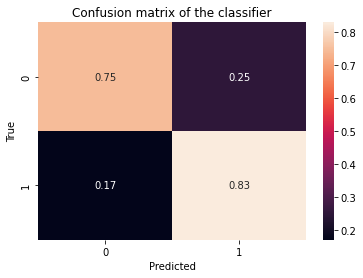

In [70]:
from sklearn import svm

clf = svm.SVC()
cv_results = cross_validate(clf, X_train, Y_train, scoring=('neg_log_loss', 'f1', 'accuracy'), cv = 5, return_train_score=True)
print(cv_results['test_accuracy'])
clf.fit(X_train, Y_train)
Y_test_predictions_svm = clf.predict(X_test)
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions_svm))
print(sklearn.metrics.classification_report(Y_test, Y_test_predictions_svm))
cm = confusion_matrix(Y_test, Y_test_predictions_svm, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Race Classification with pictures

## Image Data Load

In [ ]:
df_profile = pd.read_json('/content/drive/MyDrive/demographicPredictionData/User demo profiles.json')
df_profile.rename(columns={'id': 'user_id'}, inplace=True)
print(df_profile.shape)
print(df_profile.head())

(3609, 6)
      user_id  ...                 img_path
0       12488  ...  profile pics/60147.jpeg
1      719703  ...  profile pics/60148.jpeg
2      722153  ...  profile pics/60149.jpeg
3      749003  ...  profile pics/60150.jpeg
4  1896301728  ...  profile pics/60151.jpeg

[5 rows x 6 columns]


In [ ]:
df_users = pd.read_csv("/content/drive/MyDrive/demographicPredictionData/labeled_users.csv")
print(df_users.shape)
print(df_users.head())

(4132, 4)
    user_id  is_female  year_born  race
0   12488.0        0.0     1980.0   4.0
1  719703.0        0.0     1985.0   4.0
2  722153.0        1.0     1973.0   3.0
3  749003.0        0.0     1982.0   5.0
4  755531.0        0.0     1982.0   4.0


In [ ]:
df = pd.merge(df_profile, df_users, on="user_id")
df = df.drop(columns=['name', 'screen_name', 'description', 'lang'], axis=1)
print(df.shape)
print(df.head())

(3607, 5)
   user_id                 img_path  is_female  year_born  race
0    12488  profile pics/60147.jpeg        0.0     1980.0   4.0
1   719703  profile pics/60148.jpeg        0.0     1985.0   4.0
2   722153  profile pics/60149.jpeg        1.0     1973.0   3.0
3   749003  profile pics/60150.jpeg        0.0     1982.0   5.0
4   811618  profile pics/60152.jpeg        0.0     1987.0   3.0


In [ ]:
def find_pixels_by_path(img_path):
  path = "/content/drive/MyDrive/demographicPredictionData/" + img_path
  if exists(path):
    img = cv2.imread(path)
    return img
  else:
    return np.nan

df['pixels'] = df['img_path'].map(lambda x: find_pixels_by_path(x))

In [ ]:
print(df.shape)
print(df.head())
df = df.dropna()

(3607, 6)
   user_id  ...                                             pixels
0    12488  ...  [[[6, 90, 220], [6, 90, 220], [7, 91, 221], [7...
1   719703  ...  [[[255, 255, 255], [255, 255, 255], [255, 255,...
2   722153  ...  [[[10, 10, 10], [10, 10, 10], [10, 10, 10], [9...
3   749003  ...  [[[5, 3, 2], [6, 4, 3], [8, 6, 5], [9, 7, 6], ...
4   811618  ...  [[[209, 239, 240], [213, 243, 244], [216, 244,...

[5 rows x 6 columns]


In [ ]:
# for idx, row in df.iterrows():
#   print(row['pixels'].shape)
print(df['pixels'][0].shape)
df["pixels_data"] = df["pixels"].map(lambda x: x.reshape(-1))
print(df.shape)
print(df.head())

(224, 224, 3)
(3396, 7)
   user_id  ...                                        pixels_data
0    12488  ...  [6, 90, 220, 6, 90, 220, 7, 91, 221, 7, 91, 22...
1   719703  ...  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...
2   722153  ...  [10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, ...
3   749003  ...  [5, 3, 2, 6, 4, 3, 8, 6, 5, 9, 7, 6, 8, 6, 5, ...
4   811618  ...  [209, 239, 240, 213, 243, 244, 216, 244, 245, ...

[5 rows x 7 columns]


In [ ]:
df = df.drop(columns=['pixels'], axis=1)
print(df.shape)
print(df.head())

(3396, 6)
   user_id  ...                                        pixels_data
0    12488  ...  [6, 90, 220, 6, 90, 220, 7, 91, 221, 7, 91, 22...
1   719703  ...  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...
2   722153  ...  [10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, ...
3   749003  ...  [5, 3, 2, 6, 4, 3, 8, 6, 5, 9, 7, 6, 8, 6, 5, ...
4   811618  ...  [209, 239, 240, 213, 243, 244, 216, 244, 245, ...

[5 rows x 6 columns]


In [ ]:
df.to_csv("/content/drive/MyDrive/demographicPredictionData/image_data.csv")

## Face Detection

In [ ]:
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
from PIL import Image

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/demographicPredictionData/image_data.csv")
df = df.drop(['Unnamed: 0'], axis = 1)
print(df.shape)
print(df.head())

(3396, 6)
   user_id                 img_path  ...  race                    pixels_data
0    12488  profile pics/60147.jpeg  ...   4.0  [  6  90 220 ...  14 101 205]
1   719703  profile pics/60148.jpeg  ...   4.0  [255 255 255 ... 255 255 255]
2   722153  profile pics/60149.jpeg  ...   3.0        [10 10 10 ... 10  9 13]
3   749003  profile pics/60150.jpeg  ...   5.0              [5 3 2 ... 4 4 4]
4   811618  profile pics/60152.jpeg  ...   3.0  [209 239 240 ... 228 252 244]

[5 rows x 6 columns]


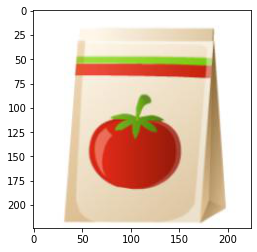

In [ ]:
# path = "/content/drive/MyDrive/demographicPredictionData/" + df['img_path'][1]
# img = plt.imread(path)
# plt.imshow(img)

In [ ]:
# face = extract_face(df['img_path'][1])
# if type(face) == np.ndarray:
#   plt.imshow(face)

In [ ]:
# test = Image.fromarray(face)
# test.save("/content/drive/MyDrive/demographicPredictionData/face pics/a.jpg")

In [ ]:


def extract_face(img_path, required_size=(224, 224)):
  path = "/content/drive/MyDrive/demographicPredictionData/" + img_path
  pixels = plt.imread(path)
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
  if len(results) == 0:
    return None
  # extract the bounding box from the first face
  x1, y1, width, height = results[0]['box']
  # bug fix
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  # extract the face
  face = pixels[y1:y2, x1:x2]
  # resize pixels to the model size
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = np.asarray(image)
  return face_array

In [ ]:
res = []
for idx,row in df.iterrows():
  face = extract_face(row['img_path'])
  if type(face) == np.ndarray:
    name = "/content/drive/MyDrive/demographicPredictionData/face pics/" + str(row['user_id']) + ".jpg"
    res.append(name)
    face_image = Image.fromarray(face)
    face_image.save(name)
  else:
    res.append(np.nan)

In [ ]:
res

In [ ]:
df['face_path'] = res

In [ ]:
df.to_csv("/content/drive/MyDrive/demographicPredictionData/face_data.csv")

## face classification

In [50]:
from keras.models import Model
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
import os.path
import sklearn
from sklearn.model_selection import KFold 

In [51]:
df = pd.read_csv("/content/drive/MyDrive/demographicPredictionData/face_data.csv")
df = df.dropna()
df = df.drop(['Unnamed: 0'], axis = 1)
print(df.shape)
print(df.columns)
print(df.head())

(2428, 7)
Index(['user_id', 'img_path', 'is_female', 'year_born', 'race', 'pixels_data',
       'face_path'],
      dtype='object')
   user_id  ...                                          face_path
4   811618  ...  /content/drive/MyDrive/demographicPredictionDa...
6   865071  ...  /content/drive/MyDrive/demographicPredictionDa...
7   988211  ...  /content/drive/MyDrive/demographicPredictionDa...
8  1025311  ...  /content/drive/MyDrive/demographicPredictionDa...
9  1143891  ...  /content/drive/MyDrive/demographicPredictionDa...

[5 rows x 7 columns]


In [52]:
def getImagePixels(path):
    img = plt.imread(path)
    #x = img.reshape(-1,)
    return img
 
df['pixels_data'] = df['face_path'].apply(getImagePixels)
print(df.head())

   user_id  ...                                          face_path
4   811618  ...  /content/drive/MyDrive/demographicPredictionDa...
6   865071  ...  /content/drive/MyDrive/demographicPredictionDa...
7   988211  ...  /content/drive/MyDrive/demographicPredictionDa...
8  1025311  ...  /content/drive/MyDrive/demographicPredictionDa...
9  1143891  ...  /content/drive/MyDrive/demographicPredictionDa...

[5 rows x 7 columns]


In [53]:
def process_label(label):
  if label == 5:
    return 0
  else:
    return label
df['label'] = df['race'].apply(process_label)
print(df['label'][:5])

4    3.0
6    4.0
7    4.0
8    4.0
9    3.0
Name: label, dtype: float64


In [7]:
df

,user_id,img_path,is_female,year_born,race,pixels_data,face_path,label
4,811618,profile pics/60152.jpeg,0.0,1987.0,3.0,"[[[18, 38, 29], [18, 38, 29], [18, 38, 29], [1...",/content/drive/MyDrive/demographicPredictionDa...,3.0
6,865071,profile pics/60154.jpeg,0.0,1995.0,4.0,"[[[124, 51, 19], [124, 51, 19], [123, 50, 18],...",/content/drive/MyDrive/demographicPredictionDa...,4.0
7,988211,profile pics/60155.jpeg,0.0,1965.0,4.0,"[[[193, 176, 169], [193, 176, 169], [193, 176,...",/content/drive/MyDrive/demographicPredictionDa...,4.0
8,1025311,profile pics/60156.jpeg,1.0,1955.0,4.0,"[[[135, 106, 66], [136, 107, 67], [136, 107, 6...",/content/drive/MyDrive/demographicPredictionDa...,4.0
9,1143891,profile pics/60157.jpeg,0.0,1976.0,3.0,"[[[253, 255, 249], [253, 255, 249], [252, 255,...",/content/drive/MyDrive/demographicPredictionDa...,3.0
...,...,...,...,...,...,...,...,...
3386,4863919091,profile pics/64261.jpeg,1.0,1964.0,4.0,"[[[106, 126, 99], [106, 126, 99], [106, 126, 9...",/content/drive/MyDrive/demographicPredictionDa...,4.0
3388,4878926855,profile pics/64263.jpeg,0.0,1983.0,4.0,"[[[185, 138, 56], [185, 138, 58], [185, 137, 6...",/content/drive/MyDrive/demographicPredictionDa...,4.0
3389,4889565747,profile pics/64264.jpeg,1.0,1977.0,4.0,"[[[80, 52, 66], [81, 53, 67], [83, 55, 69], [8...",/content/drive/MyDrive/demographicPredictionDa...,4.0
3390,4892221799,profile pics/64265.jpeg,1.0,1986.0,4.0,"[[[110, 123, 131], [107, 120, 128], [105, 118,...",/content/drive/MyDrive/demographicPredictionDa...,4.0


In [54]:
train_x, test_x, train_y, test_y = train_test_split(
    df['pixels_data'].values, df['label'].values
    , test_size=0.1, random_state=0
)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y
    , test_size=0.1, random_state=0
)
# rus = RandomUnderSampler(random_state=0)
# train_x, train_y = rus.fit_resample(train_x, train_y)

### transfer learning

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [45]:
#cross validation
train_X, test_x, train_Y, test_y = train_test_split(
    df['pixels_data'].values, df['label'].values
    , test_size=0.1, random_state=0
)
kf = KFold(n_splits=5)
for train_index , test_index in kf.split(train_X):
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(2622, (1, 1)))
  model.add(Flatten())
  model.add(Activation('softmax'))

  model.load_weights('/content/drive/MyDrive/demographicPredictionData/vgg_face_weights.h5')
  vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)

  train_x , val_x = train_X[train_index],train_X[test_index]
  train_y , val_y = train_Y[train_index],train_Y[test_index]
  train_x_processed =[]
  for img in train_x:
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encode=vgg_face(img)
    train_x_processed.append(np.squeeze(K.eval(img_encode)).tolist())
  val_x_processed =[]
  for img in val_x:
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encode=vgg_face(img)
    val_x_processed.append(np.squeeze(K.eval(img_encode)).tolist())
  train_x_processed=np.array(train_x_processed)
  train_y=np.array(train_y)
  val_x_processed=np.array(val_x_processed)
  val_y=np.array(val_y)

  classifier_model=Sequential()
  classifier_model.add(Dense(units=100,input_dim=train_x_processed.shape[1],kernel_initializer='glorot_uniform'))
  classifier_model.add(BatchNormalization())
  classifier_model.add(Activation('tanh'))
  classifier_model.add(Dropout(0.3))
  classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
  classifier_model.add(BatchNormalization())
  classifier_model.add(Activation('tanh'))
  classifier_model.add(Dropout(0.2))
  classifier_model.add(Dense(units=5,kernel_initializer='he_uniform'))
  classifier_model.add(Activation('softmax'))
  classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='nadam',metrics=['accuracy'])

  classifier_model.fit(train_x_processed,train_y)
  pred_probs = classifier_model.predict(val_x_processed)
  pred_values = np.argmax(pred_probs, axis=1)
  print(sklearn.metrics.classification_report(val_y,pred_values))

55/55 [==============================] - 5s 11ms/step - loss: 1.5160 - accuracy: 0.4405
              precision    recall  f1-score   support

         0.0       0.03      0.07      0.04        14
         1.0       0.37      0.80      0.51        45
         2.0       0.23      0.13      0.17        23
         3.0       0.06      0.06      0.06        17
         4.0       0.89      0.71      0.79       338

    accuracy                           0.65       437
   macro avg       0.32      0.35      0.31       437
weighted avg       0.74      0.65      0.68       437

55/55 [==============================] - 2s 9ms/step - loss: 1.5129 - accuracy: 0.4548
              precision    recall  f1-score   support

         0.0       0.03      0.31      0.06        16
         1.0       0.33      0.80      0.47        35
         2.0       0.06      0.04      0.04        28
         3.0       0.04      0.10      0.06        10
         4.0       0.91      0.43      0.58       348

    accura

In [56]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [57]:
model.load_weights('/content/drive/MyDrive/demographicPredictionData/vgg_face_weights.h5')

In [58]:
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)

In [59]:
train_x_processed =[]
for img in train_x:
  img=np.expand_dims(img,axis=0)
  img=preprocess_input(img)
  img_encode=vgg_face(img)
  train_x_processed.append(np.squeeze(K.eval(img_encode)).tolist())
val_x_processed =[]
for img in val_x:
  img=np.expand_dims(img,axis=0)
  img=preprocess_input(img)
  img_encode=vgg_face(img)
  val_x_processed.append(np.squeeze(K.eval(img_encode)).tolist())


In [61]:
test_x_processed =[]
for img in test_x:
  img=np.expand_dims(img,axis=0)
  img=preprocess_input(img)
  img_encode=vgg_face(img)
  test_x_processed.append(np.squeeze(K.eval(img_encode)).tolist())

In [62]:
train_x_processed=np.array(train_x_processed)
train_y=np.array(train_y)
val_x_processed=np.array(val_x_processed)
val_y=np.array(val_y)
test_x_processed=np.array(test_x_processed)
test_y=np.array(test_y)

In [63]:
classifier_model=Sequential()
classifier_model.add(Dense(units=100,input_dim=train_x_processed.shape[1],kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=5,kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))
classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='nadam',metrics=['accuracy'])

In [ ]:
classifier_model.fit(train_x_processed,train_y,epochs=100,validation_data=(val_x_processed,val_y))

In [ ]:
# Save model for later use
tf.keras.models.save_model(classifier_model,'/content/drive/MyDrive/demographicPredictionData/train/face_classifier_model.h5')

In [ ]:
classifier_model=tf.keras.models.load_model('/content/drive/MyDrive/demographicPredictionData/train/face_classifier_model.h5')

In [ ]:
predictions = classifier_model.predict(test_x_processed)

In [ ]:
pred = np.argmax(predictions, axis=1)
pred

In [ ]:
print(sklearn.metrics.classification_report(test_y,pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.38      0.36      0.37        14
         2.0       0.00      0.00      0.00        11
         3.0       1.00      0.40      0.57         5
         4.0       0.86      0.94      0.90       202

    accuracy                           0.81       243
   macro avg       0.45      0.34      0.37       243
weighted avg       0.76      0.81      0.78       243



### CNN

In [ ]:
train_x_tensor = tf.convert_to_tensor(train_x.tolist(), dtype=tf.float32)
train_y_tensor = tf.convert_to_tensor(train_y.tolist(), dtype=tf.float32)

In [ ]:
val_x_tensor = tf.convert_to_tensor(val_x.tolist(), dtype=tf.float32)
val_y_tensor = tf.convert_to_tensor(val_y.tolist(), dtype=tf.float32)

In [35]:
tf.random.set_seed(0)

def build_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy', metrics='accuracy'):
    '''
    Creates a CNN with num_classes, activation, loss and metrics as arguments. These will help make the
    different models.
    '''
    
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = inputs

    # Augment the data by randomly flipping and rotating the images
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(x)
    # x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=[metrics]        
    )
    
    return model

In [36]:
race_cnn_model = build_model(5, activation='softmax', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_path = "/content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [37]:
race_cnn_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_116 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_117 (Conv2D)         (None, 112, 112, 128)     7385

In [38]:
train_X, test_x, train_Y, test_y = train_test_split(
    df['pixels_data'].values, df['label'].values
    , test_size=0.1, random_state=0
)
kf = KFold(n_splits=5)
for train_index , test_index in kf.split(train_X):
  
  train_x , val_x = train_X[train_index],train_X[test_index]
  train_y , val_y = train_Y[train_index],train_Y[test_index]

  train_x_tensor = tf.convert_to_tensor(train_x.tolist(), dtype=tf.float32)
  train_y_tensor = tf.convert_to_tensor(train_y.tolist(), dtype=tf.float32)

  val_x_tensor = tf.convert_to_tensor(val_x.tolist(), dtype=tf.float32)
  val_y_tensor = tf.convert_to_tensor(val_y.tolist(), dtype=tf.float32)

  race_history = race_cnn_model.fit(
    train_x_tensor,
    train_y_tensor,
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.2, patience=4,
                                                    min_lr=0.001, verbose=1),
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8,
                                                verbose=1, mode='auto',
                                                restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)],
    verbose=1
  )

  pred_prob = race_cnn_model.predict(val_x_tensor)
  y_pred = np.argmax(pred_prob, axis = 1)
  print(sklearn.metrics.classification_report(val_y,y_pred))


Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 1.9975 - accuracy: 0.3090 
Epoch 00001: val_loss improved from inf to 12.40088, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt
22/22 [==============================] - 614s 28s/step - loss: 1.9975 - accuracy: 0.3090 - val_loss: 12.4009 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 1.6182 - accuracy: 0.3784 
Epoch 00002: val_loss improved from 12.40088 to 3.55505, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt
22/22 [==============================] - 604s 28s/step - loss: 1.6182 - accuracy: 0.3784 - val_loss: 3.5550 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 1.4087 - accuracy: 0.5229 
Epoch 00003: val_loss improved from 3.55505 to 1.36558, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.c

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        14
         1.0       0.29      0.38      0.33        45
         2.0       0.00      0.00      0.00        23
         3.0       0.00      0.00      0.00        17
         4.0       0.80      0.90      0.85       338

    accuracy                           0.73       437
   macro avg       0.22      0.26      0.24       437
weighted avg       0.65      0.73      0.69       437

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.7539 
Epoch 00001: val_loss improved from inf to 0.93600, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt
22/22 [==============================] - 580s 26s/step - loss: 0.8152 - accuracy: 0.7539 - val_loss: 0.9360 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.7960 - accuracy: 0.7675 
Epoch 00002: val_loss did not improve

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.64      0.20      0.30        35
         2.0       0.00      0.00      0.00        28
         3.0       0.00      0.00      0.00        10
         4.0       0.81      0.99      0.89       348

    accuracy                           0.81       437
   macro avg       0.29      0.24      0.24       437
weighted avg       0.70      0.81      0.73       437

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.7921 - accuracy: 0.7568 
Epoch 00001: val_loss improved from inf to 0.83116, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt
22/22 [==============================] - 587s 27s/step - loss: 0.7921 - accuracy: 0.7568 - val_loss: 0.8312 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.7690 
Epoch 00002: val_loss improved from 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.88      0.18      0.30        38
         2.0       0.00      0.00      0.00        20
         3.0       0.00      0.00      0.00        10
         4.0       0.81      1.00      0.89       348

    accuracy                           0.81       437
   macro avg       0.34      0.24      0.24       437
weighted avg       0.72      0.81      0.74       437

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.8011 
Epoch 00001: val_loss improved from inf to 0.82222, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt
22/22 [==============================] - 640s 29s/step - loss: 0.6535 - accuracy: 0.8011 - val_loss: 0.8222 - val_accuracy: 0.7971 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.8162 
Epoch 00002: val_loss did not improve

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        10
         1.0       1.00      0.09      0.16        45
         2.0       1.00      0.04      0.07        27
         3.0       0.00      0.00      0.00        15
         4.0       0.79      1.00      0.88       340

    accuracy                           0.79       437
   macro avg       0.56      0.23      0.22       437
weighted avg       0.78      0.79      0.71       437

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8627 
Epoch 00001: val_loss improved from inf to 0.64736, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt
22/22 [==============================] - 629s 29s/step - loss: 0.4291 - accuracy: 0.8627 - val_loss: 0.6474 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8670 
Epoch 00002: val_loss did not improve

In [ ]:
# race_cnn_model.load_weights(checkpoint_path)

In [ ]:
race_history = race_cnn_model.fit(
    train_x_tensor,
    train_y_tensor,
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.2, patience=4,
                                                    min_lr=0.001, verbose=1),
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8,
                                                verbose=1, mode='auto',
                                                restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)],
    verbose=1
)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.9147 - accuracy: 0.2980 
Epoch 00001: val_loss improved from inf to 10.94547, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt
27/27 [==============================] - 340s 13s/step - loss: 1.9147 - accuracy: 0.2980 - val_loss: 10.9455 - val_accuracy: 0.0350 - lr: 0.0010
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 1.5967 - accuracy: 0.4333 
Epoch 00002: val_loss improved from 10.94547 to 3.50902, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.ckpt
27/27 [==============================] - 334s 12s/step - loss: 1.5967 - accuracy: 0.4333 - val_loss: 3.5090 - val_accuracy: 0.1028 - lr: 0.0010
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 1.3187 - accuracy: 0.5738 
Epoch 00003: val_loss improved from 3.50902 to 1.18798, saving model to /content/drive/MyDrive/demographicPredictionData/train/cp-cnn-race.c

In [ ]:
race_acc = race_cnn_model.evaluate(val_x_tensor, val_y_tensor)

10/10 [==============================] - 14s 1s/step - loss: 0.7340 - accuracy: 0.8253


In [ ]:
race_history.history['accuracy']

[0.29800936579704285,
 0.43325525522232056,
 0.5737704634666443,
 0.6604215502738953,
 0.7014051675796509,
 0.7318500876426697,
 0.7488290667533875,
 0.7540983557701111,
 0.7646369934082031,
 0.7892271876335144]

In [33]:
def plot_confusion_matrix(y_true, y_pred, labels, predict_idx):
    '''
    Plot confusion matrix from y_true and y_pred with labels.
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cm = sklearn.metrics.confusion_matrix(y_test[:,predict_idx], y_pred)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.show()

In [ ]:
pred_prob = race_cnn_model.predict(val_x_tensor)
pred_prob

array([[0.01058174, 0.00990071, 0.01513472, 0.00515839, 0.95922446],
       [0.03681039, 0.05599701, 0.05761221, 0.03233169, 0.81724864],
       [0.03018907, 0.01858941, 0.02810105, 0.02324248, 0.8998779 ],
       ...,
       [0.00436815, 0.00396154, 0.00344487, 0.00217477, 0.98605067],
       [0.04312815, 0.06642451, 0.05613064, 0.03036558, 0.80395114],
       [0.01043169, 0.00967481, 0.01608444, 0.01393534, 0.9498737 ]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(pred_prob, axis = 1)

In [ ]:
y_pred

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [ ]:
print(sklearn.metrics.classification_report(val_y,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.33      0.06      0.10        18
         2.0       0.00      0.00      0.00        13
         3.0       0.00      0.00      0.00         9
         4.0       0.83      1.00      0.91       241

    accuracy                           0.83       292
   macro avg       0.23      0.21      0.20       292
weighted avg       0.71      0.83      0.75       292



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
